# Front matter

_Important_: On first run, set CACHING to True

In [1]:
CACHING = False
EXPERIMENTAL = False

## Set path

In [2]:
PATH_YIELD_ENGINE = 'src'

def set_paths() -> None:
    """
    set correct working directory and python path when started from within PyCharm
    """
    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir)
        os.chdir(cwd)
    
    print(f"working dir is '{os.getcwd()}'")
                             
    if PATH_YIELD_ENGINE not in sys.path:
        sys.path.insert(0, PATH_YIELD_ENGINE)
    
    print(f"added `{sys.path[0]}` to python paths")

set_paths()

working dir is 'C:\Users\martin florent\Documents\projects\yield-engine'
added `src` to python paths


## Imports

In [21]:
import logging
import os
import pickle

import numpy as np
import pandas as pd
from lightgbm.sklearn import LGBMRegressor
from matplotlib import cm
from matplotlib.pyplot import figure
from matplotlib.ticker import ScalarFormatter
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import matplotlib.pyplot as plt

import tests
from tests.model import make_simple_transformer
from tests.paths import TEST_DATA_CSV
from yieldengine import Sample
from yieldengine.dendrogram import DendrogramDrawer
from yieldengine.dendrogram.style import FeatMapStyle, LineStyle
from yieldengine.preprocessing.impute import SimpleImputerDF
from yieldengine.preprocessing.selection import BorutaDF
from yieldengine.model.prediction import PredictorCV
from yieldengine.df.pipeline import PipelineDF
from yieldengine.model.selection import Model, ModelGrid, ModelRanker
from yieldengine.model.validation import CircularCrossValidator
from yieldengine.simulation import UnivariateSimulation

In [4]:
%matplotlib inline

In [5]:
PATH_TMP = 'tmp'
MI_PKL = os.path.join(PATH_TMP, 'model_inspector.pkl')
MP_PKL = os.path.join(PATH_TMP, 'model_predictor.pkl')

In [6]:
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Load the data file

In [7]:
inputfile_config = tests.read_test_config(section="inputfile")

batch_df = pd.read_csv(
    filepath_or_buffer=TEST_DATA_CSV,
    delimiter=inputfile_config["delimiter"],
    header=inputfile_config["header"],
    decimal=inputfile_config["decimal"],
)

batch_df = batch_df.drop(columns=["Date", "Batch Id"])

# replace values of +/- infinite with n/a, then drop all n/a columns:
batch_df = batch_df.replace([np.inf, -np.inf], np.nan).dropna(
    axis=1, how="all"
)
batch_df.head()

,Step4 Fermentation Sensor Data Phase2 Pressure Val04 (mbar),Step4-6 RawMat Vendor Compound09 Purity Loss on Drying (g),Step6 Fermentation Sensor Data Phase3 Agitation Speed Val03 No1 (rounds per minutes),Step2 RawMat Internal Compound15 Number Openings (#),Step3 Media Age at Inoculation (days),Step3 RawMat Internal Compound15 Number Openings (#),Step4 RawMat Internal Compound01 QC (id),Step3 Media Compound17 Age at Inoculation (days),Step4-6 RawMat Internal Compound18 Age (days),Step6 RawMat Internal Compound04 Vendor (name),...,Step3 RawMat Vendor Compound05 Manufacturing Date (numeric date),Step1 Media Compound17 Weight (ml),Step5 Fermentation Sensor Data Phase1 Duration (minutes),Step6 Fermentation Sensor Data Phase3 Agitation Speed Sum No2 (rounds per minutes),Step6 Fermentation Sensor Data Phase3 Oxygen Val04 (%),Step6 Fermentation Sensor Data Phase3 Temperature Val03 (°C),Step6 Media Compound20 Age at Inoculation (days),Step4 RawMat Vendor Compound12 Manufacturing Date (numeric date),Step5 Fermentation Wait Duration (minutes),Step4-6 RawMat Internal Compound04 Age (days)
0,NaN,NaN,NaN,13.0,21.0,13.0,FP,36.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,NaN,NaN,NaN,3.0,80963.0,767.0,NaN
1,NaN,NaN,NaN,13.0,21.0,13.0,FP,36.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,NaN,NaN,NaN,3.0,80963.0,767.0,NaN
2,NaN,NaN,NaN,13.0,21.0,13.0,FP,36.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,NaN,NaN,NaN,3.0,80963.0,767.0,NaN
3,790.284723,NaN,417.871938,13.0,25.0,13.0,FP,39.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,97499.901386,31.394059,68.835293,4.0,80963.0,727.0,NaN
4,783.702715,NaN,413.294366,13.0,25.0,13.0,FP,39.0,NaN,COMPOUND PROVIDER INC,...,80953.0,174.907237,NaN,97190.471353,28.432164,68.764230,4.0,80963.0,727.0,NaN


In [42]:
TARGET = "Yield"
# define a Sample based on the test batch_file
sample = Sample(observations=batch_df, target_name=TARGET)
sample

In [9]:
# define the circular cross validator with 10 folds
circular_cv = CircularCrossValidator(test_ratio=0.2, num_splits=10)

circular_cv

CircularCrossValidator(num_splits=None, test_ratio=None)

In [10]:
if not CACHING:
    boruta_selector = PipelineDF(steps=[
        (
            'preprocess', 
            make_simple_transformer(
                impute_median_columns=sample.features_by_type(Sample.DTYPE_NUMERICAL).columns,
                one_hot_encode_columns=sample.features_by_type(Sample.DTYPE_OBJECT).columns,
            )
        ),
        (
            'boruta', 
            BorutaDF(
                estimator=RandomForestRegressor(n_jobs=4),
                max_iter=100,
                n_estimators='auto', 
                verbose=2, 
                random_state=42
            )
        )
    ])
    
    feature_selection = boruta_selector.fit_transform(
            sample.features, 
            sample.target
        )
    
    selected_features = boruta_selector.columns_original

    sample_post_boruta = sample.select_features(selected_features)
    
    selected_features.to_frame()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	29
Tentative: 	24
Rejected: 	117


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	29
Tentative: 	24
Rejected: 	117


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	29
Tentative: 	24
Rejected: 	117


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	29
Tentative: 	24
Rejected: 	117


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	31
Tentative: 	22
Rejected: 	117


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	31
Tentative: 	20
Rejected: 	119


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	31
Tentative: 	20
Rejected: 	119


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	31
Tentative: 	20
Rejected: 	119


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	122


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	122


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	122


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	122


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	122


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	123


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	123


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	123


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	123


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	123


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	31
Tentative: 	14
Rejected: 	125


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	31
Tentative: 	14
Rejected: 	125


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	31
Tentative: 	14
Rejected: 	125


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	31
Tentative: 	14
Rejected: 	125


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	31
Tentative: 	13
Rejected: 	126


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	32
Tentative: 	11
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	32
Tentative: 	11
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	32
Tentative: 	11
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	32
Tentative: 	11
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	32
Tentative: 	11
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	32
Tentative: 	11
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	32
Tentative: 	11
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	32
Tentative: 	11
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	32
Tentative: 	11
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	33
Tentative: 	10
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	34
Tentative: 	9
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	34
Tentative: 	9
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	34
Tentative: 	9
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	35
Tentative: 	8
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	35
Tentative: 	8
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	35
Tentative: 	8
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	35
Tentative: 	8
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	35
Tentative: 	8
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	36
Tentative: 	7
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	36
Tentative: 	7
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	36
Tentative: 	7
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	36
Tentative: 	7
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	36
Tentative: 	7
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	36
Tentative: 	7
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	36
Tentative: 	7
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	37
Tentative: 	6
Rejected: 	127


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	37
Tentative: 	5
Rejected: 	128


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	37
Tentative: 	5
Rejected: 	128


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	37
Tentative: 	5
Rejected: 	128


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	37
Tentative: 	5
Rejected: 	128


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	37
Tentative: 	5
Rejected: 	128


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	37
Tentative: 	5
Rejected: 	128
Iteration: 	99 / 100
Confirmed: 	37
Tentative: 	5
Rejected: 	128


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	37
Tentative: 	5
Rejected: 	128


C:\Users\martin florent\AppData\Local\Continuum\anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


In [11]:
# define a transformer step based on the sample
if not CACHING:
    preprocessor = make_simple_transformer(
            impute_median_columns=sample_post_boruta.features_by_type(Sample.DTYPE_NUMERICAL).columns,
            one_hot_encode_columns=sample_post_boruta.features_by_type(Sample.DTYPE_OBJECT).columns,
    )
    preprocessor

In [12]:
if not CACHING:
    # define a Model with a preprocessing pipeline
    lgbm = ModelGrid(
                model=Model(
                    preprocessing=preprocessor, estimator=LGBMRegressor()
                ),
                estimator_parameters={
                    "max_depth": [5, 10],
                    "min_split_gain": [0.1, 0.2],
                    "num_leaves": [50, 100, 200],
                    "random_state": [42],
                },
    )
    lgbm

In [13]:
if not CACHING:
    # define a ModelRanker
    model_ranker: ModelRanker = ModelRanker(
            grids=[lgbm], cv=circular_cv, scoring="r2"
        )

    # run the ModelRanker to retrieve a ranking
    model_ranking = model_ranker.run(sample=sample_post_boruta)
    # noinspection PyStatementEffect
else:
    model_ranking = None
    
model_ranking

[ModelEvaluation(model=<yieldengine.model.Model object at 0x000001D87DA25088>, parameters={'estimator__max_depth': 10, 'estimator__min_split_gain': 0.1, 'estimator__num_leaves': 50, 'estimator__random_state': 42}, scoring={'test_score': <yieldengine.model.selection.ModelScoring object at 0x000001D87D321BE0>}, ranking_score=-0.48399573591454487),
 ModelEvaluation(model=<yieldengine.model.Model object at 0x000001D87D3045C8>, parameters={'estimator__max_depth': 10, 'estimator__min_split_gain': 0.1, 'estimator__num_leaves': 100, 'estimator__random_state': 42}, scoring={'test_score': <yieldengine.model.selection.ModelScoring object at 0x000001D87D3214A8>}, ranking_score=-0.48399573591454487),
 ModelEvaluation(model=<yieldengine.model.Model object at 0x000001D87DA05AC8>, parameters={'estimator__max_depth': 10, 'estimator__min_split_gain': 0.1, 'estimator__num_leaves': 200, 'estimator__random_state': 42}, scoring={'test_score': <yieldengine.model.selection.ModelScoring object at 0x000001D87D3

In [14]:
if not CACHING:
    # retrieve the best model
    best_model = model_ranking[0]
    # noinspection PyStatementEffect
    best_model
else:
    best_model = None

In [15]:
if not CACHING:
    # define a PredictorCV
    mp = PredictorCV(
        model=best_model.model,
        cv=circular_cv,
        sample=sample
    )

    with open(MP_PKL, 'wb') as f:
        pickle.dump(mp, f)
else:
    with open(MP_PKL, 'rb') as f:
        mp = pickle.load(f)

mp

# Simulation Example starts here

In [16]:
sim = UnivariateSimulation(predictor=mp)

In [17]:
parameterized_feature = "Step4-6 RawMat Vendor Compound08 Purity (#)"

yield_change = sim.simulate_yield_change(
    parameterized_feature=parameterized_feature,
    parameter_values=UnivariateSimulation.observed_feature_values(
        feature_name=parameterized_feature,
        sample=sample
    ),
)

yield_change.head()

,split_id,parameter_value,relative_yield_change
0,0,28.0,-0.015381
1,1,28.0,-0.005069
2,2,28.0,-0.000018
3,3,28.0,-0.000829
4,4,28.0,-0.006987


In [18]:
UnivariateSimulation.aggregate_simulated_yield_change(
            results_per_split=yield_change, percentiles=[10, 50, 90]
)

relative_yield_change                            
                        percentile_10 percentile_50 percentile_90
parameter_value                                                  
24.0                        -0.015544     -0.010919     -0.000748
28.0                        -0.017924     -0.010825     -0.000748
30.0                         0.001954      0.012455      0.016605
31.0                         0.002785      0.012958      0.017191
32.0                         0.002827      0.012958      0.017111

## Interactive inspection of UnivariateSimulation
Run the cell below and then select a feature to simulate...

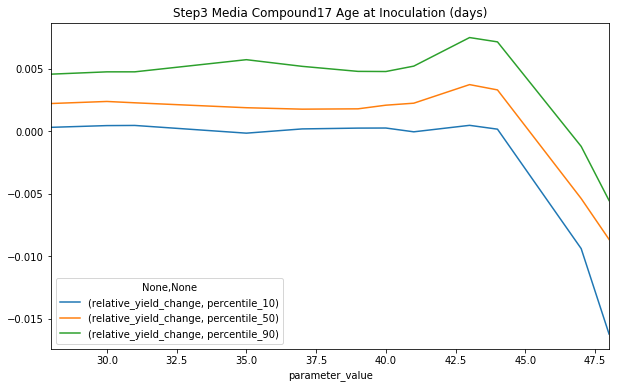

In [82]:
from IPython.display import display, clear_output
import ipywidgets as widgets

dd = widgets.Dropdown(
    options=sample_post_boruta.features.columns,
    description='Feature:',
    disabled=False,
    layout={"width":"550px"}
)

btn = widgets.Button(
    description='Simulate'
)

def plot_simulation(feature:str):
    yield_change = sim.simulate_yield_change(
            parameterized_feature=feature,
            parameter_values=UnivariateSimulation.observed_feature_values(
                feature_name=feature,
                sample=sample,
                min_relative_frequency=0.03,
                limit_observations=100
            ),
    )
    
    yield_change_aggr = UnivariateSimulation.aggregate_simulated_yield_change(
                    results_per_split=yield_change, percentiles=[10, 50, 90])
    
    yield_change_aggr.plot(title=feature, figsize=(10,6))

def on_click(btn):
    clear_output()
    display(widgets.HBox([dd, btn]))
    plot_simulation(feature=dd.value)
    
btn.on_click(on_click)    

display(widgets.HBox([dd, btn]))

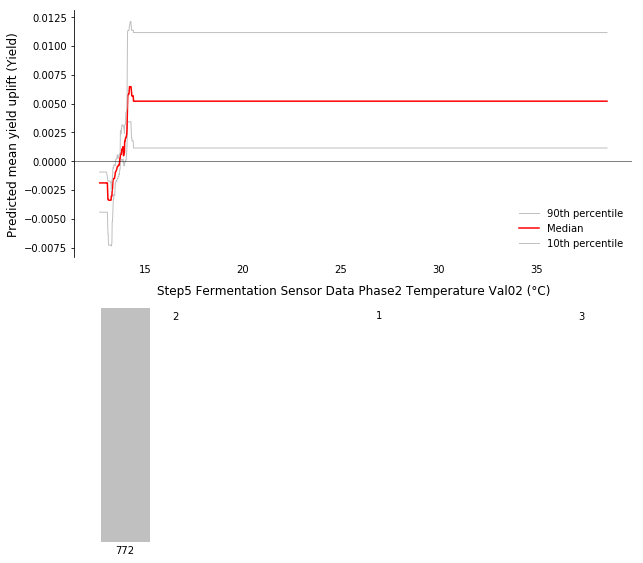

In [87]:
from IPython.display import display, clear_output
import ipywidgets as widgets


dd = widgets.Dropdown(
    options=sample_post_boruta.features.columns,
    description='Feature:',
    disabled=False,
    layout={"width":"550px"}
)

btn = widgets.Button(
    description='Simulate'
)

def plot_simulation(feature:str):
    yield_change = sim.simulate_yield_change(
            parameterized_feature=feature,
            parameter_values=UnivariateSimulation.observed_feature_values(
                feature_name=feature,
                sample=sample,
                min_relative_frequency=0.03,
                limit_observations=100
            ),
    )
    
    yield_change_aggr = UnivariateSimulation.aggregate_simulated_yield_change(
                    results_per_split=yield_change, percentiles=[10, 50, 90])
    
    XLABEL_TITLE = f"{feature}"
    YLABEL_TITLE = f"Predicted mean yield uplift ({TARGET})"
    COLOR1 = 'red'
    COLOR2 = 'silver'
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10), sharex=True)
    
    # plot lines of prediction
    ax1.set_xlabel(XLABEL_TITLE, color='black', labelpad=10, fontsize=12)
    ax1.set_ylabel(YLABEL_TITLE, color='black', fontsize=12)
    line1, = ax1.plot(yield_change_aggr.index, yield_change_aggr.iloc[:,0], color=COLOR2, linewidth=1)
    line2, = ax1.plot(yield_change_aggr.index, yield_change_aggr.iloc[:,1], color=COLOR1)
    line3, = ax1.plot(yield_change_aggr.index, yield_change_aggr.iloc[:,2], color=COLOR2, linewidth=1)
    ax1.axhline(y=0, color='black', linewidth=.5)
    ax1.tick_params(axis='x', labelcolor='black')
    for pos in ['top', 'right', 'bottom']:
        ax1.spines[pos].set_visible(False)
    ax1.tick_params(axis='x', labelbottom=True, bottom=False)
    ax1.legend((line3, line2, line1), 
               ('90th percentile', 'Median', '10th percentile'), 
               frameon=False,
              )
    
    # plot the histogram
    x = sample.features[feature].dropna()
    hist_range = (min(yield_change_aggr.index), max(yield_change_aggr.index))
    n, bins, patches = ax2.hist(x, edgecolor='white', color=COLOR2, range=hist_range)
    bins1 = pd.Series(bins).rolling(window=2).mean().shift(-1).dropna()
    ax2.invert_yaxis()
    ax2.tick_params(axis='y', labelcolor='black')
    max_y = max(n)
    y_offset = max_y * 0.05
    for (x,y) in zip(bins1, n):
        if y>0:
            ax2.text(x, y + y_offset, str(int(y)), 
                    color='black', 
                    horizontalalignment='center')
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    for pos in ['top', 'right', 'left', 'bottom']:
        ax2.spines[pos].set_visible(False)
    plt.subplots_adjust(hspace=.2)
    plt.show()

def on_click(btn):
    clear_output()
    display(widgets.HBox([dd, btn]))
    plot_simulation(feature=dd.value)
    
btn.on_click(on_click)    
display(widgets.HBox([dd, btn]))